<a href="https://colab.research.google.com/github/Ananassio/Data-Minig-Lab/blob/main/Week_10/node2vec_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph representation learning with node2vec

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/05/15<br>
**Last modified:** 2021/05/15<br>
**Description:** Implementing the node2vec model to generate embeddings for movies from the MovieLens dataset.

## Introduction

Learning useful representations from objects structured as graphs is useful for
a variety of machine learning (ML) applications—such as social and communication networks analysis,
biomedicine studies, and recommendation systems.
[Graph representation Learning](https://www.cs.mcgill.ca/~wlh/grl_book/) aims to
learn embeddings for the graph nodes, which can be used for a variety of ML tasks
such as node label prediction (e.g. categorizing an article based on its citations)
and link prediction (e.g. recommending an interest group to a user in a social network).

[node2vec](https://arxiv.org/abs/1607.00653) is a simple, yet scalable and effective
technique for learning low-dimensional embeddings for nodes in a graph by optimizing
a neighborhood-preserving objective. The aim is to learn similar embeddings for
neighboring nodes, with respect to the graph structure.

Given your data items structured as a graph (where the items are represented as
nodes and the relationship between items are represented as edges),
node2vec works as follows:

1. Generate item sequences using (biased) random walk.
2. Create positive and negative training examples from these sequences.
3. Train a [word2vec](https://www.tensorflow.org/tutorials/text/word2vec) model
(skip-gram) to learn embeddings for the items.

In this example, we demonstrate the node2vec technique on the
[small version of the Movielens dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
to learn movie embeddings. Such a dataset can be represented as a graph by treating
the movies as nodes, and creating edges between movies that have similar ratings
by the users. The learnt movie embeddings can be used for tasks such as movie recommendation,
or movie genres prediction.

This example requires `networkx` package, which can be installed using the following command:

```shell
pip install networkx
```

## Setup

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Download the MovieLens dataset and prepare the data

The small version of the MovieLens dataset includes around 100k ratings
from 610 users on 9,742 movies.

First, let's download the dataset. The downloaded folder will contain
three data files: `users.csv`, `movies.csv`, and `ratings.csv`. In this example,
we will only need the `movies.dat`, and `ratings.dat` data files.

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

Then, we load the data into a Pandas DataFrame and perform some basic preprocessing.

In [3]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


Let's inspect a sample instance of the `ratings` DataFrame.

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


Next, let's check a sample instance of the `movies` DataFrame.

In [5]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


Implement two utility functions for the `movies` DataFrame.

In [6]:

def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]


## Construct the Movies graph

We create an edge between two movie nodes in the graph if both movies are rated
by the same user >= `min_rating`. The weight of the edge will be based on the
[pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information)
between the two movies, which is computed as: `log(xy) - log(x) - log(y) + log(D)`, where:

* `xy` is how many users rated both movie `x` and movie `y` with >= `min_rating`.
* `x` is how many users rated movie `x` >= `min_rating`.
* `y` is how many users rated movie `y` >= `min_rating`.
* `D` total number of movie ratings >= `min_rating`.

### Step 1: create the weighted edges between movies.

In [7]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 624.75it/s]


### Step 2: create the graph with the nodes and the edges

To reduce the number of edges between nodes, we only add an edge between movies
if the weight of the edge is greater than `min_weight`.

In [8]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 444565.93it/s]


Let's display the total number of nodes and edges in the graph.
Note that the number of nodes is less than the total number of movies,
since only the movies that have edges to other movies are added.

In [9]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


Let's display the average node degree (number of neighbours) in the graph.

In [10]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


### Step 3: Create vocabulary and a mapping from tokens to integer indices

The vocabulary is the nodes (movie IDs) in the graph.

In [11]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## Implement the biased random walk

A random walk starts from a given node, and randomly picks a neighbour node to move to.
If the edges are weighted, the neighbour is selected *probabilistically* with
respect to weights of the edges between the current node and its neighbours.
This procedure is repeated for `num_steps` to generate a sequence of *related* nodes.

The [*biased* random walk](https://en.wikipedia.org/wiki/Biased_random_walk_on_a_graph) balances between **breadth-first sampling**
(where only local neighbours are visited) and **depth-first sampling**
(where  distant neighbours are visited) by introducing the following two parameters:

1. **Return parameter** (`p`): Controls the likelihood of immediately revisiting
a node in the walk. Setting it to a high value encourages moderate exploration,
while setting it to a low value would keep the walk local.
2. **In-out parameter** (`q`): Allows the search to differentiate
between *inward* and *outward* nodes. Setting it to a high value biases the
random walk towards local nodes, while setting it to a low value biases the walk
to visit nodes which are further away.

In [12]:

def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks


## Generate training data using the biased random walk

You can explore different configurations of `p` and `q` to different results of
related movies.

In [13]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:06<00:00, 212.31it/s]

Number of walks generated: 7025


## Generate positive and negative examples

To train a skip-gram model, we use the generated walks to create positive and
negative training examples. Each example includes the following features:

1. `target`: A movie in a walk sequence.
2. `context`: Another movie in a walk sequence.
3. `weight`: How many times these two movies occured in walk sequences.
4. `label`: The label is 1 if these two movies are samples from the walk sequences,
otherwise (i.e., if randomly sampled) the label is 0.

### Generate examples

In [14]:

def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:17<00:00, 405.12it/s]


Let's display the shapes of the outputs

In [15]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (882617,)
Contexts shape: (882617,)
Labels shape: (882617,)
Weights shape: (882617,)


### Convert the data into `tf.data.Dataset` objects

In [16]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## Train the skip-gram model

Our skip-gram is a simple binary classification model that works as follows:

1. An embedding is looked up for the `target` movie.
2. An embedding is looked up for the `context` movie.
3. The dot product is computed between these two embeddings.
4. The result (after a sigmoid activation) is compared to the label.
5. A binary crossentropy loss is used.

In [17]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

### Implement the model

In [18]:

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


### Train the model

We instantiate the model and compile it.

In [19]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

Let's plot the model.

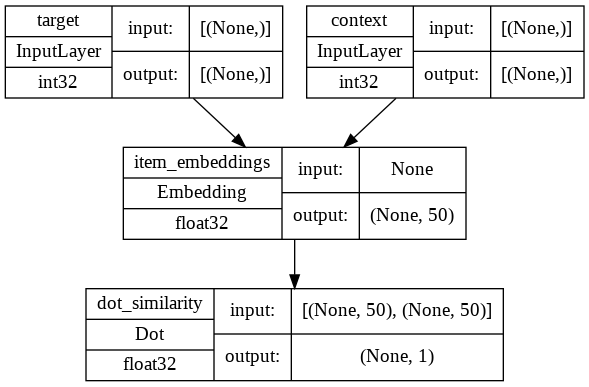

In [20]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

Now we train the model on the `dataset`.

In [21]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
861/861 [==============================] - 7s 7ms/step - loss: 2.4479
Epoch 2/10
861/861 [==============================] - 7s 8ms/step - loss: 2.3384
Epoch 3/10
861/861 [==============================] - 10s 11ms/step - loss: 2.3311
Epoch 4/10
861/861 [==============================] - 7s 9ms/step - loss: 2.3277
Epoch 5/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3242
Epoch 6/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3202
Epoch 7/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3165
Epoch 8/10
861/861 [==============================] - 8s 9ms/step - loss: 2.3133
Epoch 9/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3104
Epoch 10/10
861/861 [==============================] - 6s 7ms/step - loss: 2.3078


Finally we plot the learning history.

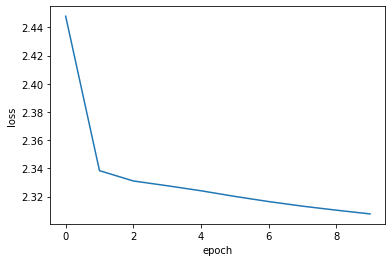

In [22]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Analyze the learnt embeddings.

In [23]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


### Find related movies

Define a list with some movies called `query_movies`.

In [24]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

Get the embeddings of the movies in `query_movies`.

In [25]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

Compute the [consine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the embeddings of `query_movies`
and all the other movies, then pick the top k for each.

In [26]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

Display the top related movies in `query_movies`.

In [27]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Lord of the Rings: The Return of the King, The (2003)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Fight Club (1999)
- Star Wars: Episode IV - A New Hope (1977)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Silence of the Lambs, The (1991)
- Aliens (1986)
- Godfather, The (1972)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Twister (1996)
- Beauty and the Beast (1991)
- Aladdin (1992)
- Ghost (1990)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Silence of the Lambs, The (1991)
- Braveheart (1995)
- Aliens (1986)
- Lion King, The (1994)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Rear Window (1954)
- 2001: A Space Odyssey (1968)
- Apo

### Visualize the embeddings using the Embedding Projector

In [28]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()

Download the `embeddings.tsv` and `metadata.tsv` to analyze the obtained embeddings
in the [Embedding Projector](https://projector.tensorflow.org/).